In [29]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

In [30]:
tpath = r'cool_tests'
path = r'Final_cooling_sys_data'

Reading the synthetic data

In [31]:
def moving_avg(x, N=1000):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

In [32]:
dsets = []
coollevel = []
fanspeed = []
cooltemp = []
for i in range(31):
    dsets.append(pd.read_csv(path + '\\final_cooling_dset_' + str(i)+'.csv'))
    dsets[i]['65263-111'] = dsets[i]['65263-111'].mode()[0].astype(int)         #replacing synthetic float coolant levels with int modes to remove noise
    coollevel.append(dsets[i]['65263-111'][::100])

    dsets[i].loc[dsets[i]['64817-1598'] != 0, '64817-1598'] = 4096.
    fanspeed.append(dsets[i]['64817-1598'][::100])
    fanspeed[i] = fanspeed[i].astype(int)

    vals = moving_avg(dsets[i]['65262-110'])
    cooltemp.append(vals[::250])

for i in range(8):
    dsets.append(pd.read_csv(path + '\\faulty_cooling_dset_' + str(i)+'.csv'))
    dsets[31+i]['65263-111'] = dsets[31+i]['65263-111'].astype(int)
    
    coollevel.append(dsets[31+i]['65263-111'][::100])

    fanspeed.append(dsets[31+i]['64817-1598'][::100])
    fanspeed[31+i] = fanspeed[31+i].astype(int)

    vals = moving_avg(dsets[31+i]['65262-110'])
    cooltemp.append(vals[::250])


Creating a formatted time series sets for each component

In [33]:
formatted_level = to_time_series_dataset(coollevel)
formatted_speed = to_time_series_dataset(fanspeed)
formatted_temp = to_time_series_dataset(cooltemp)
print("Coolant Level Shape: " + str(formatted_level.shape))
print("Fan Speed Shape: " + str(formatted_speed.shape))
print("Coolant Temperature Shape: " + str(formatted_temp.shape))

Coolant Level Shape: (39, 926, 1)
Fan Speed Shape: (39, 926, 1)
Coolant Temperature Shape: (39, 367, 1)


In [34]:
#Scaling
formatted_level = TimeSeriesScalerMeanVariance().fit_transform(formatted_level)
#formatted_temp = TimeSeriesScalerMinMax(value_range=(0,1)).fit_transform(formatted_temp)

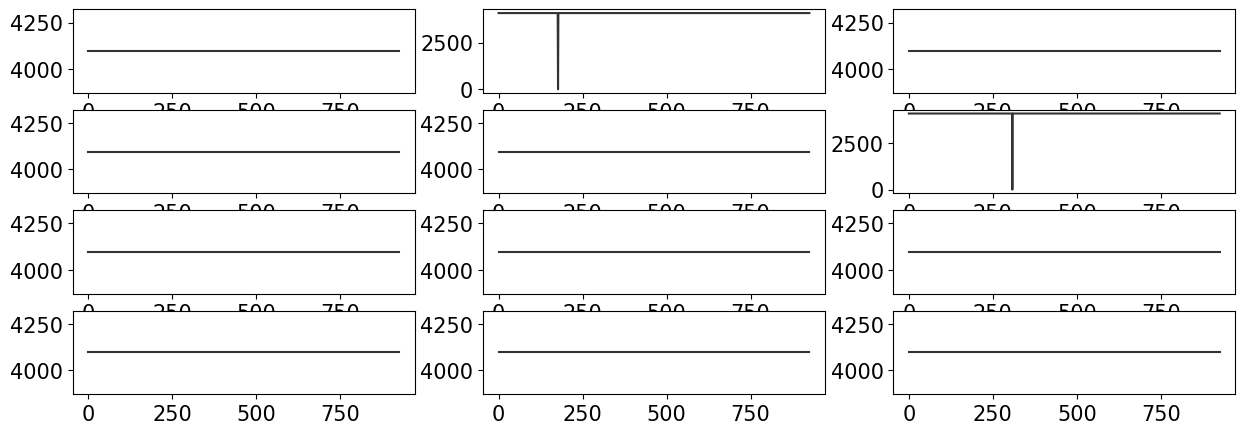

In [35]:
#Normal fans
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_speed[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

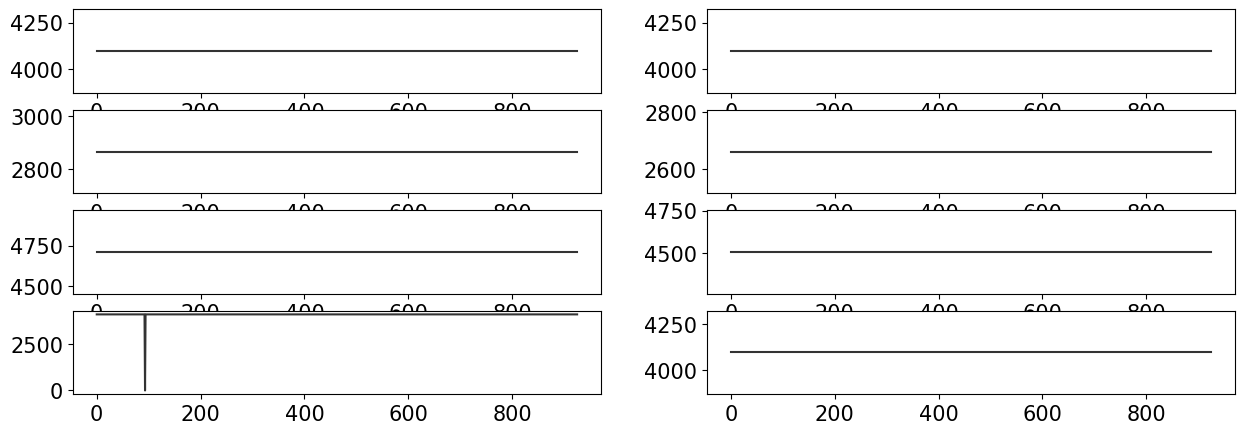

In [36]:
#Some fans with faults
plt.figure(figsize=(15,5))
for yi in range(8):
    plt.subplot(4, 2, yi + 1)
    plt.plot(formatted_speed[31+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

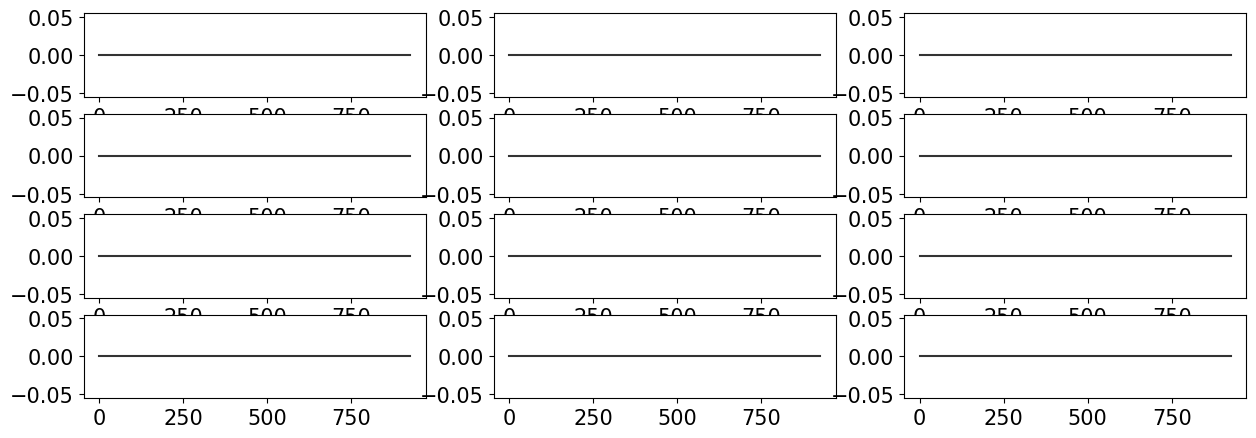

In [37]:
#Normal levels
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_level[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

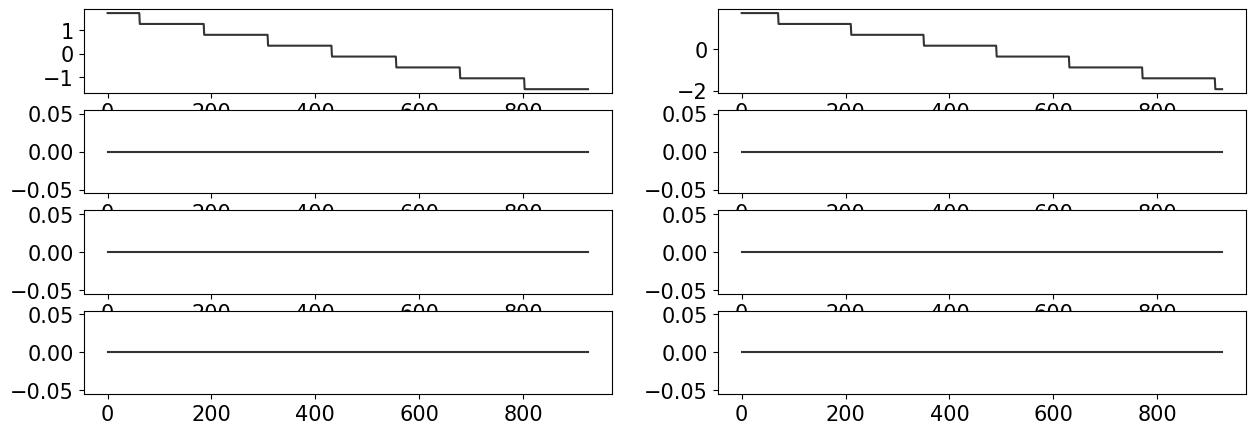

In [38]:
#some faulty coolant levels
plt.figure(figsize=(15,5))
for yi in range(8):
    plt.subplot(4, 2, yi + 1)
    plt.plot(formatted_level[31+yi].ravel(), "k-", alpha=.8)

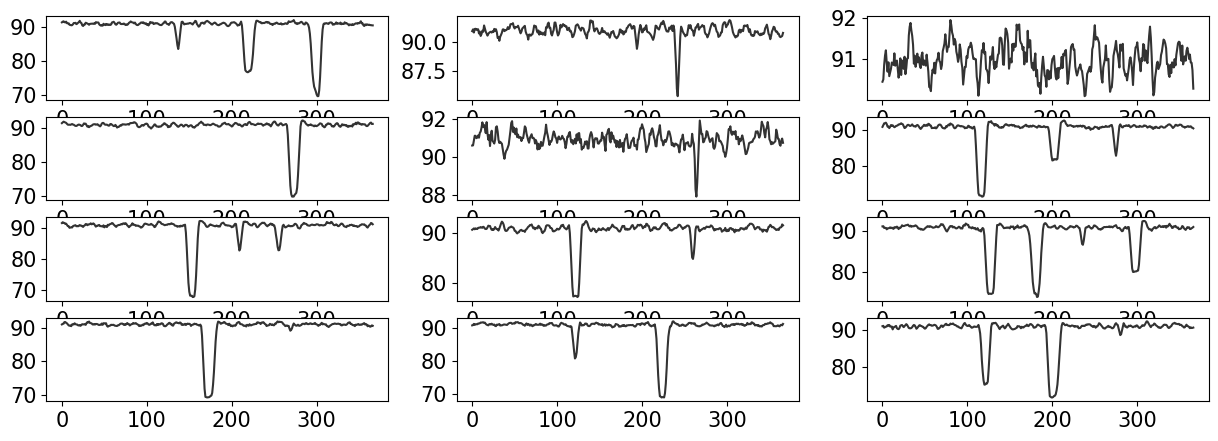

In [39]:
#Normal levels
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_temp[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

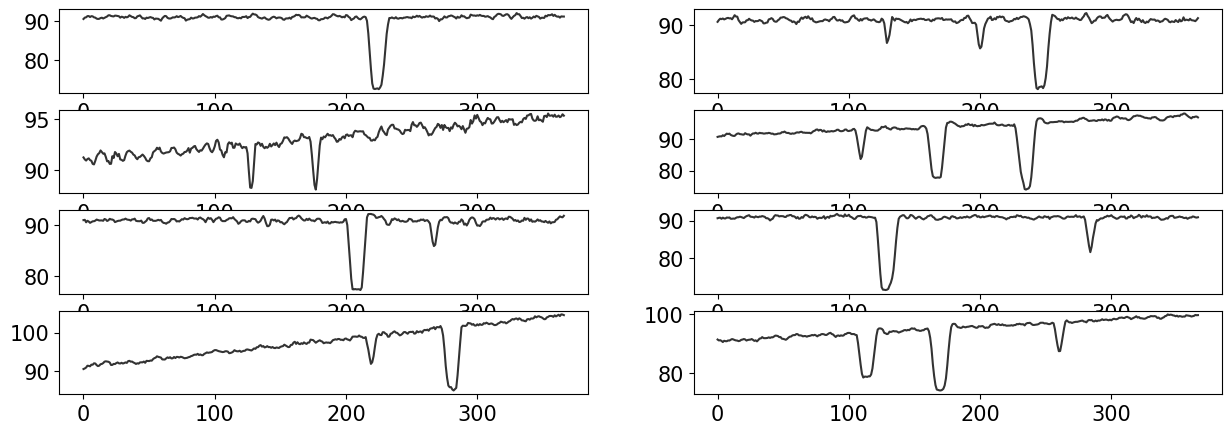

In [40]:
plt.figure(figsize=(15,5))
for yi in range(8):
    plt.subplot(4, 2, yi + 1)
    plt.plot(formatted_temp[31+yi].ravel(), "k-", alpha=.8)

In [41]:
plt.rcParams.update({'font.size': 15})

Checking number of Clusters using Dynamic Time Warping
The methods are the Elbow method and Silhoutte Score

In [42]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_level)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_level)
    sil_score = silhouette_score(formatted_level, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.9910895098272337
[0.28926923960870127]
0.9487179487179487
[0.28926923960870127, 0.0]
0.9487179487179487
[0.28926923960870127, 0.0, inf]
0.9487179487179487
[0.28926923960870127, 0.0, inf, inf]
0.9487179487179487
[0.28926923960870127, 0.0, inf, inf, inf]


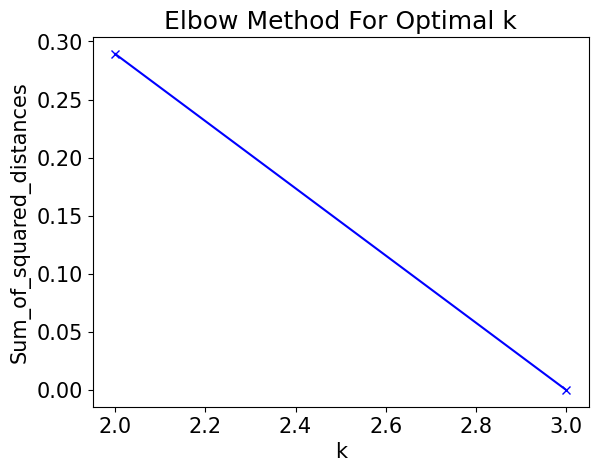

In [43]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA k-means
DBA silhoutte: 0.99
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 33 34 35 36 37 38]
[31 32]


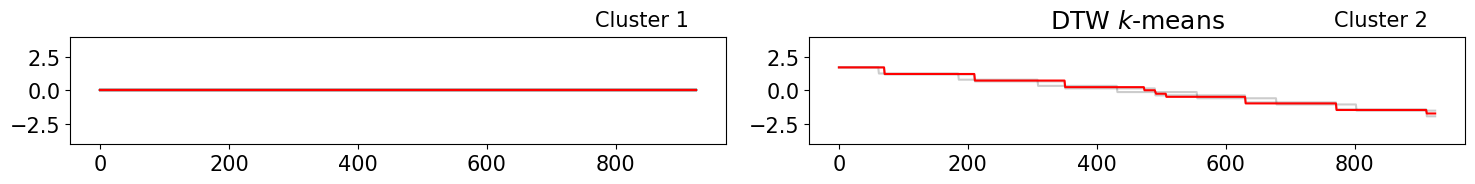

In [44]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_level)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_level, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_level[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
#print(np.where(y_pred_dba_km == 2)[0])

plt.tight_layout()
plt.show()

In [45]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_speed)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_speed)
    sil_score = silhouette_score(formatted_speed, preds, metric="dtw")
    print(sil_score)
    print(Sum_of_squared_distances)

0.9374028178011994
[14872254.993070241]
0.9125068340363521
[14872254.993070241, 3087294.4835164836]
0.9706446728729077
[14872254.993070241, 3087294.4835164836, 997824.3589743591]
0.9407754091648539
[14872254.993070241, 3087294.4835164836, 997824.3589743591, 498912.17948717956]
0.8974358974358975
[14872254.993070241, 3087294.4835164836, 997824.3589743591, 498912.17948717956, 0.0]


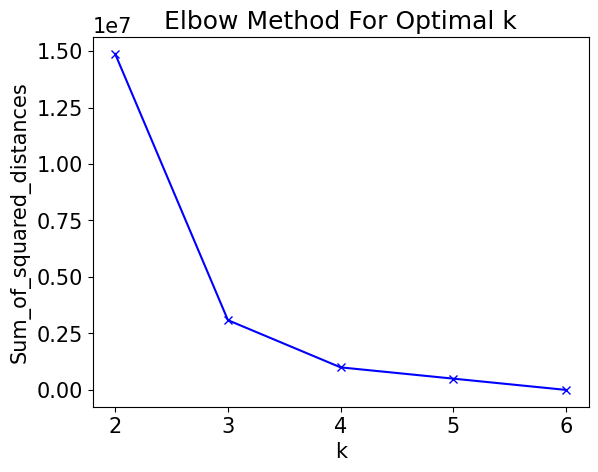

In [46]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA k-means
DBA silhoutte: 0.91
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 37 38]
[33 34]
[35 36]


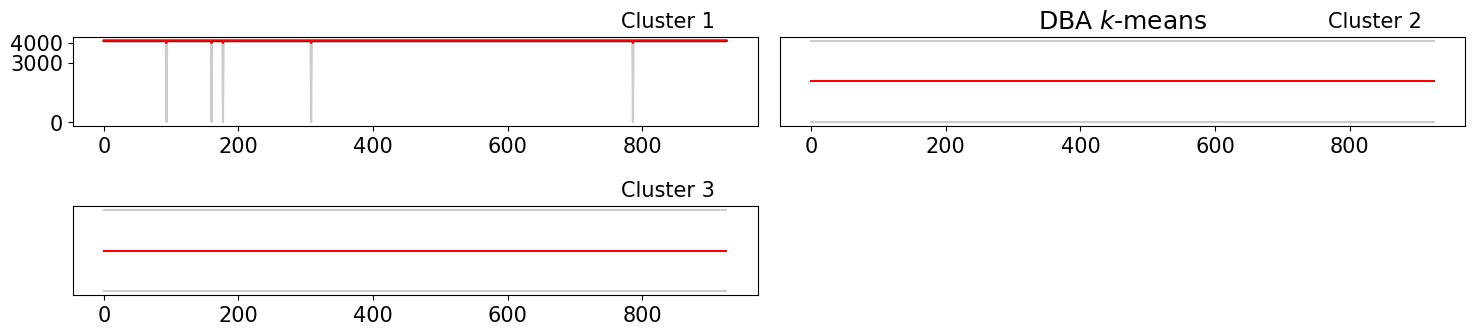

In [47]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_speed)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_speed, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_speed[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.yticks([0, 3000, 4000])
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])
plt.tight_layout()
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 37 38]
[33 34]
[35 36]


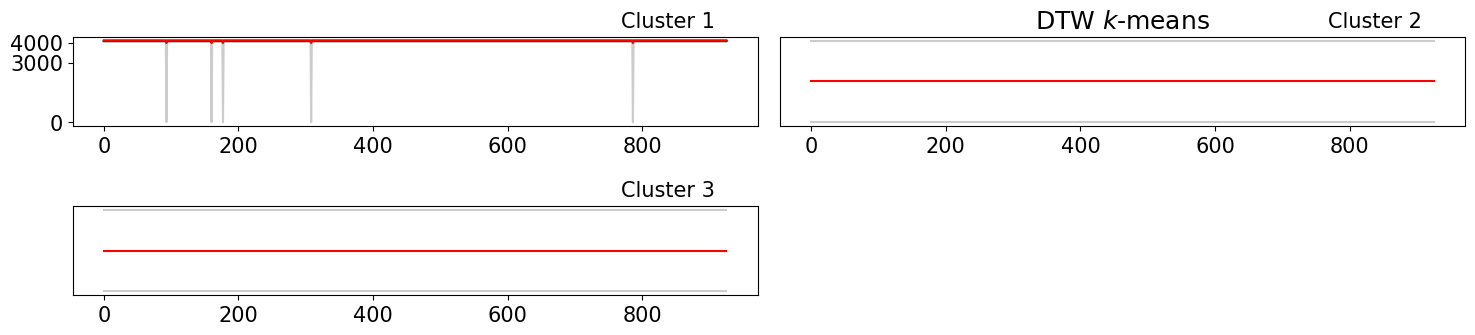

In [48]:
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_speed[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
        #plt.ylim(0, 5000)
        plt.yticks([0, 3000, 4000])
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])
plt.tight_layout()
plt.show()

Checking number of Clusters using Euclidean
The methods are the Elbow method and Silhoutte Score

In [49]:
#Coolant Level Using Eucliedean as the metric
Sum_of_squared_distances = []
K = range(2,5)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_level)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_level)
    sil_score = silhouette_score(formatted_level, preds, metric="dtw")
    print(sil_score)
    print(Sum_of_squared_distances)

0.9910895098272337
[0.5286878552682699]
0.9487179487179487
[0.5286878552682699, 0.0]
0.9487179487179487
[0.5286878552682699, 0.0, inf]


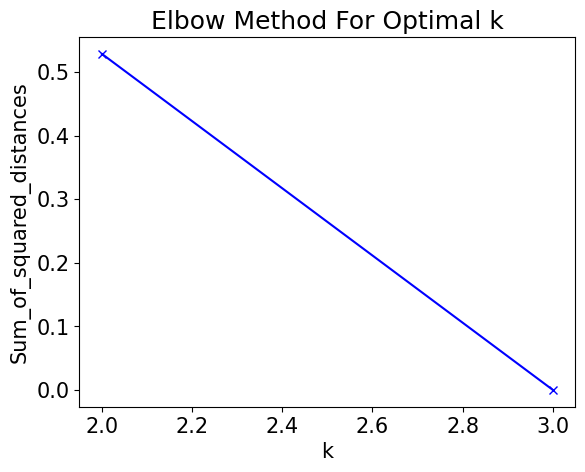

In [50]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Euclidean silhouette: 0.99
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 33 34 35 36 37 38]
[31 32]


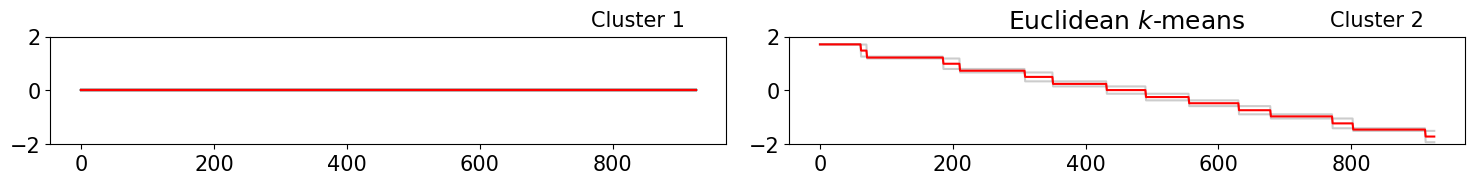

In [51]:
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_level)
print("Euclidean silhouette: {:.2f}".format(silhouette_score(formatted_level, y_pred_dba_km)))
plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_level[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.ylim(-2, 2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        

print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
plt.tight_layout()
plt.show()

In [52]:
#Fan speed using Euclidean as the Metric
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_speed)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_speed)
    sil_score = silhouette_score(formatted_speed, preds)
    print(sil_score)

0.9374028178011994
0.9125068340363521
0.8691651680967006
0.8251842596543574
0.5734265734265734


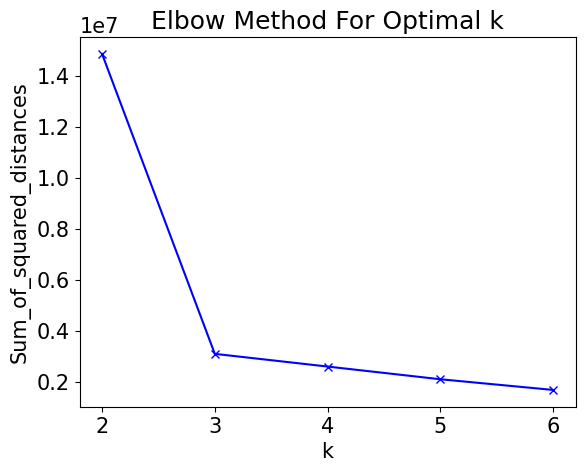

In [53]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Euclidean silhouette: 0.89
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 35 36 37 38]
[34]
[33]


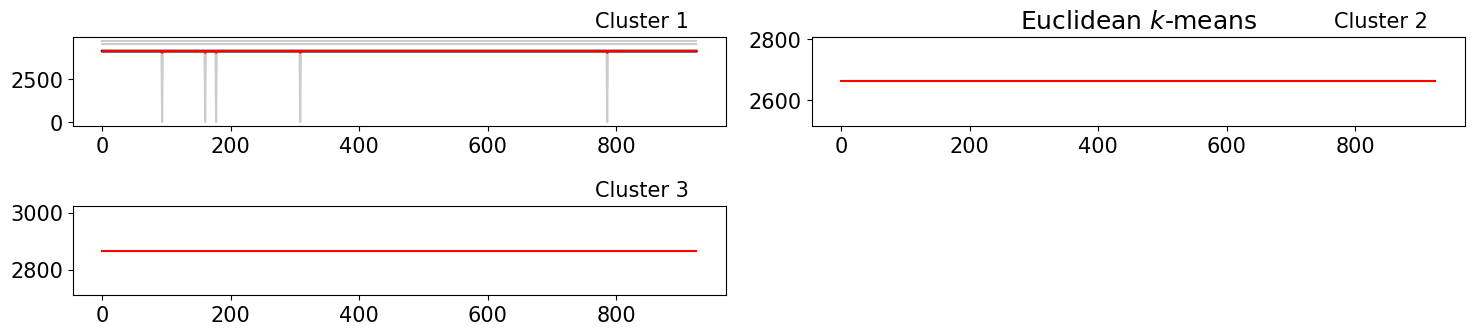

In [54]:
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_speed)
print("Euclidean silhouette: {:.2f}".format(silhouette_score(formatted_speed, y_pred_dba_km)))

plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_speed[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        

print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])
plt.tight_layout()
plt.show()

### Coolant Temperature will be tested below only using the DTW method due to the variance and noise

In [55]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_temp)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_temp)
    sil_score = silhouette_score(formatted_temp, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.6351895018923739
[324.89026685103596]
0.3880022333174424
[324.89026685103596, 214.81697632589925]
0.4054306966310271
[324.89026685103596, 214.81697632589925, 144.94978269760546]
0.41206877033346345
[324.89026685103596, 214.81697632589925, 144.94978269760546, 110.04782980499155]
0.4016559839152256
[324.89026685103596, 214.81697632589925, 144.94978269760546, 110.04782980499155, 100.37562399428904]


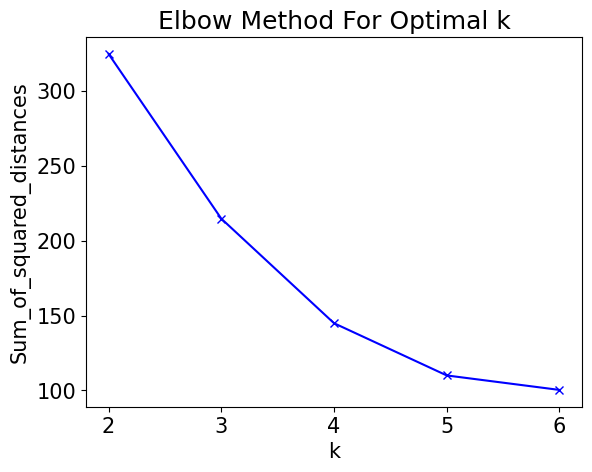

In [56]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA silhoutte: 0.64
[34 37 38]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 35 36]


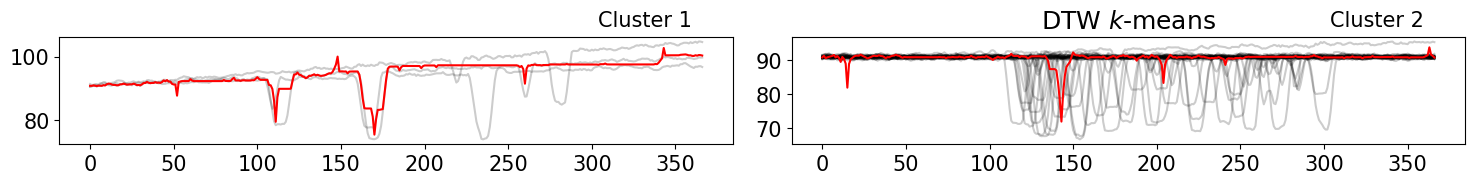

In [57]:
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=10,
                          max_iter_barycenter=500,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_temp)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_temp, y_pred_dba_km, metric="dtw")))

plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_temp[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        

print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
plt.tight_layout()
plt.show()

DBA silhoutte: 0.39


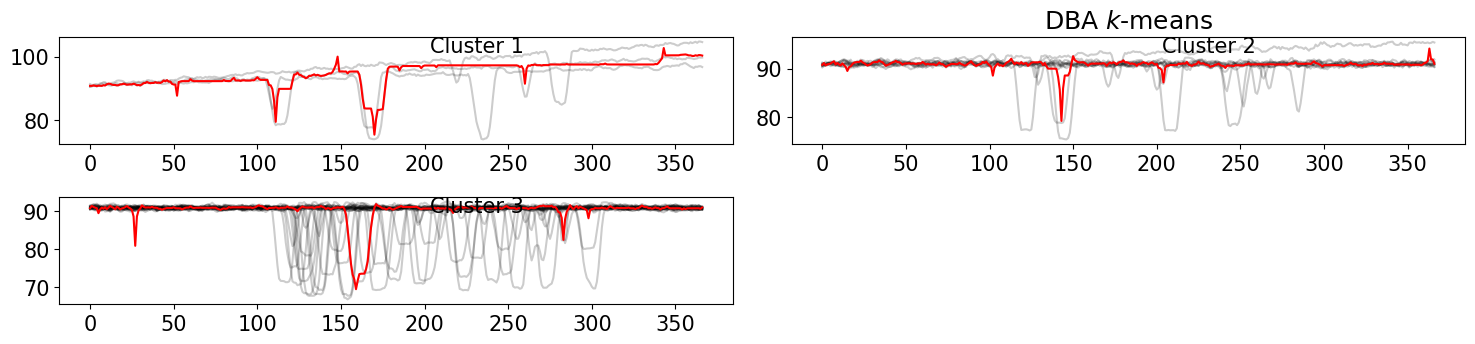

In [58]:
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_temp)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_temp, y_pred_dba_km, metric="dtw")))

plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_temp[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

DBA silhoutte: 0.41


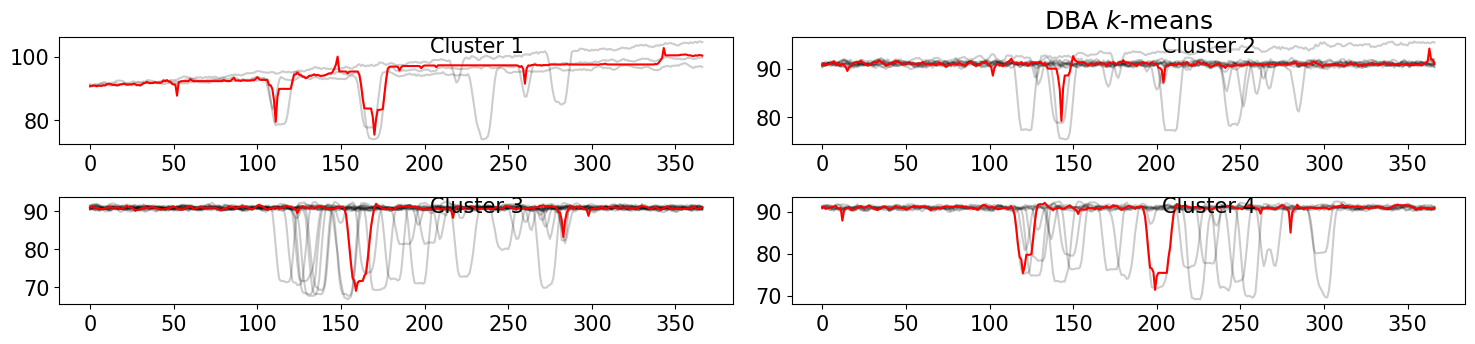

In [59]:
dba_km = TimeSeriesKMeans(n_clusters=4,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_temp)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_temp, y_pred_dba_km, metric="dtw")))

plt.figure(figsize=(15,5))
for yi in range(4):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_temp[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()